Variable	Definition
survival	Survival	     0 = No, 1 = Yes   
pclass	    Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
Sex  	    Sex	  
Age	        Age in years	  
sibsp	    # of siblings / spouses aboard the Titanic	  
parch	    # of parents / children aboard the Titanic	  
ticket	    Ticket number	  
fare	    Passenger fare 

In [1]:
# import 
# algebra tools
import math
import numpy as np
import itertools

# preprocessing tools
import pandas as pd 

# visualization tools
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# sk-learn tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

# keras tools
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000000)

In [3]:
# upload train and test files
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
data = [train_df, test_df]

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## looks like we have a little bit of preprocessing to do, before we build our model.

## missing Embarked: 2 Cases

Looks like we only have 2 missing values.

In [7]:
#findout where the 2 missing embarked values are
np.where(train_df['Embarked'].isnull())

(array([ 61, 829], dtype=int64),)

In [8]:
train_df.iloc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We found them, two women paid the same fare, same class and share the same ticket number. Maybe friends (or coworkers?) traveling together. We can try using the fare cost and ticket class to estimate their embarkment location.

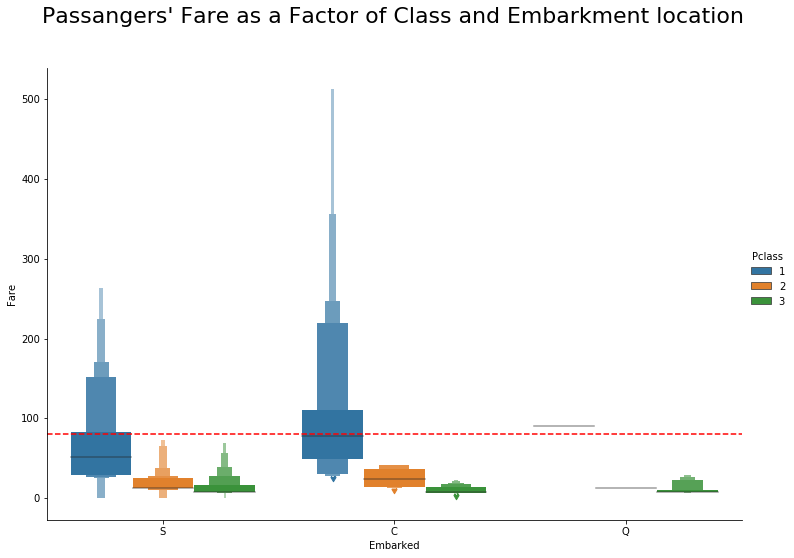

In [9]:
#construct mini dataframe, dropna to avoid errors
embarked_df = train_df.drop([61,829], axis=0)


#visualize: Embarkment location vs. Pclass and Fare


# plt.style.use(['dark_background'])
# plt.suptitle('figure title', color='w')
sns.catplot(x='Embarked', y='Fare', hue='Pclass', kind='boxen', data= train_df, height=7, aspect=1.5)
#sns.set(rc={'axes.facecolor':'.9', 'figure.facecolor':'.9'})
#plt.set(alpha=0.0)
#plt.plot(alpha=0.0)
#plt.set_alpha(0.0)
plt.axhline(y=80, color='r', ls='--') #dotted line at $80 far price
plt.suptitle('Passangers\' Fare as a Factor of Class and Embarkment location', fontsize=22, y = 1.1)

plt.show()

Looks like our passangers in question paid the median fare of first class passangers who embarked in 'C'.

In [10]:
#based on the box catplot, let's replace missing Embarked values
train_df.loc[[61,829],'Embarked']= 'C'
train_df.iloc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,C


## missing Fare: 1 Case

In [11]:
#findout where the 1 missing Fare value is
np.where(test_df['Fare'].isnull())

(array([152], dtype=int64),)

In [12]:
test_df.iloc[[152]]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [13]:
# using the previous method to calculate Embarked from Fare and Pclass,
# we can calculate (estimate) the fare that Mr.Thomas paid

test_df.groupby(['Pclass', 'Embarked']).median()

PassengerId   Age  SibSp  Parch      Fare
Pclass Embarked                                           
1      C              1091.0  43.0    0.0    0.0  75.24585
       Q              1303.0  37.0    1.0    0.0  90.00000
       S              1095.0  42.0    0.0    0.0  51.67085
2      C              1156.0  27.0    0.0    0.0  15.04580
       Q               942.0  61.0    0.0    0.0  11.52915
       S              1131.5  26.0    0.0    0.0  21.00000
3      C              1065.0  21.0    0.0    0.0   7.22920
       Q              1092.0  24.0    0.0    0.0   7.75000
       S              1092.0  24.0    0.0    0.0   8.05000

In [14]:
# there we go, the median value for someone who embarked in S, with a Pclass of 3 is 8.05000
test_df.loc[[152],'Fare']= 8.05000
test_df.iloc[[152]]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,NaN,S


## Cabin --> Deck

In [15]:
#fillna in'Cabin' with U0 and replace with 'Deck' 

import re


#deck_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}


data = [train_df, test_df]
for variable in data:
    #fill missing values in 'Cabin' with U0, save over 'Cabin'
    variable['Cabin'] = variable['Cabin'].fillna("U0")
    #create new column 'Deck' map first leter in 'Cabin' to 'Deck'
    variable['Deck'] = variable['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    # use dictionary 'deck' to change ABC-G to 123-8
    #variable['Deck'] = variable['Deck'].map(deck_dict).fillna(0).astype(int)
    #drop 'Cabin' 
    variable.drop('Cabin', axis=1, inplace=True)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U


In [17]:
# train_df['Deck'].value_counts()

In [18]:
# test_df['Deck'].value_counts()

## Age

Looks like we have a lot of missing age values.

In [19]:
for variable in data:
    #fill missing values in 'Cabin' with U0, save over 'Cabin'
    variable['Age'] = variable['Age'].fillna(value=0).astype(int)

In [20]:
train_df['Age'].isnull().sum()

0

In [21]:
test_df['Age'].isnull().sum()

0

In [22]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,U


## Name --> Title

when looking at the names column, I notice that within each passanger name there is a title included. A person's title could give us information on their: socioeconomic status, level of education, age and gender. Although we already have some of that information already this might still be useful in someway. We should definitely pull the titles out and use them for our models later on.

In [23]:
#compile passangers' titles from 'Name' and put that information in new column 'Title' 
#this could have been much shorter code using regx but i wanted to see if it could be done this way
#the fact that the titles are always between a ", " and a ". " makes this simple
new_col = train_df["Name"].str.split(", ", n = 3, expand = True)
new_col2 = new_col[1].str.split(". ", n = 3, expand = True)
train_df["Title"]= new_col2[0]

In [24]:
#do the same manipulation to the test_df to avoid errors later on
new_col3 = test_df["Name"].str.split(", ", n = 3, expand = True)
new_col4 = new_col3[1].str.split(". ", n = 3, expand = True)
test_df["Title"]= new_col4[0]

In [25]:
#replace less common names to more common ones
##previously tried using a for loop with .map()  to a dictionary like I did in the capin situation but with no luck. 


train_df.replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Lady', 
                        'Major', 'Mlle', 'Mme', 'Ms', 'Sir', 'th', 'Dona'], 
                       ['Mr', 'Mr', 'Mr', 'Mr', 'Mrs',
                        'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Miss', 'Mrs'], inplace= True)

#do the same manipulation to the testing data
test_df.replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Lady', 
                        'Major', 'Mlle', 'Mme', 'Ms', 'Sir', 'th', 'Dona'], 
                       ['Mr', 'Mr', 'Mr', 'Mr', 'Mrs',
                        'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Miss', 'Mrs'], inplace= True)

In [26]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,U,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,U,Miss


In [27]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,Q,U,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,S,U,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,Q,U,Mr


##  Parch and SibSp --> FamilySize

In [28]:
#okay it worked, let's use a for loop to make changes to both train_df and test_df
data = [train_df, test_df]

for variable in data:
    variable["FamSize"]= variable["Parch"] + variable["SibSp"] + 1
    #will not drop 'Parch' and 'SibSp' because i think they might still be useful seperatly
    
# train_df.head()

In [29]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,U,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,U,Miss,1


In [30]:
#its getting a little too crowded now, lets try to remove some of the stuff we won't need anymore
for variable in data:
    variable.drop('PassengerId', axis=1, inplace=True)
    variable.drop('Name', axis=1, inplace=True)
#     variable.drop('Fare', axis=1, inplace=True)
#     variable.drop('Age', axis=1, inplace=True)
    variable.drop('Ticket', axis=1, inplace=True)

In [31]:
train_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,FamSize
0,0,3,male,22,1,0,7.2500,S,U,Mr,2
1,1,1,female,38,1,0,71.2833,C,C,Mrs,2
2,1,3,female,26,0,0,7.9250,S,U,Miss,1


## encode data

In [32]:
cat_columns= ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

In [33]:
#encode all values into 1s and 0s
encoded_train_data = pd.get_dummies(train_df, columns= cat_columns , drop_first=False)
encoded_test_data = pd.get_dummies(test_df, columns= cat_columns , drop_first=False)
encoded_test_data.reindex(columns = encoded_train_data.columns, fill_value=0)
encoded_test_data = encoded_test_data.reindex(columns = encoded_train_data.columns, fill_value=0)

In [34]:
#standardize features by removing the mean and scaling to unit variance (1 stdev)
ss = StandardScaler()
features= encoded_train_data.columns.drop('Survived').tolist()
ss.fit(encoded_train_data[features].values)

standardized_train_values = encoded_train_data.copy()
standardized_test_values = encoded_test_data.copy()

standardized_train_values[features] = ss.transform(encoded_train_data[features]).astype('float64')
standardized_test_values[features] = ss.transform(encoded_test_data[features]).astype('float64')

In [35]:
standardized_train_values.head(3)

,Survived,Age,SibSp,Parch,Fare,FamSize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,-0.101401,0.432793,-0.473674,-0.502445,0.059160,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.485576,-0.307562,0.619306,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.544925,-0.088986,-0.216803,-0.513644,0.834951,-0.407714,-0.082339
1,1,0.808338,0.432793,-0.473674,0.786845,0.059160,1.767767,-0.510152,-1.107926,1.355574,-1.355574,2.059412,-0.307562,-1.614710,-0.130856,-0.235981,3.755222,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,-1.835115,-0.088986,-0.216803,-0.513644,-1.197675,2.452702,-0.082339
2,1,0.126034,-0.474545,-0.473674,-0.488854,-0.560975,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.544925,-0.088986,-0.216803,1.946875,-1.197675,-0.407714,-0.082339


In [36]:
standardized_test_values.head(3)

,Survived,Age,SibSp,Parch,Fare,FamSize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,0.580903,-0.474545,-0.473674,-0.490783,-0.560975,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.485576,3.251373,-1.614710,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.544925,-0.088986,-0.216803,-0.513644,0.834951,-0.407714,-0.082339
1,0,1.320066,0.432793,-0.473674,-0.507479,0.059160,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.544925,-0.088986,-0.216803,-0.513644,-1.197675,2.452702,-0.082339
2,0,2.172946,-0.474545,-0.473674,-0.453367,-0.560975,-0.565685,1.960202,-1.107926,-0.737695,0.737695,-0.485576,3.251373,-1.614710,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,0.544925,-0.088986,-0.216803,-0.513644,0.834951,-0.407714,-0.082339


## shuffle data

In [37]:
#shuffle training data
standardized_train_values = standardized_train_values.sample(frac=1).reset_index(drop=True)
standardized_train_values.head(3)

,Survived,Age,SibSp,Parch,Fare,FamSize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,1,0.012316,-0.474545,2.008933,-0.312172,0.679295,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.130856,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,14.891273,-0.03352,-1.835115,-0.088986,-0.216803,-0.513644,-1.197675,2.452702,-0.082339
1,1,0.353468,-0.474545,-0.473674,0.497830,-0.560975,1.767767,-0.510152,-1.107926,1.355574,-1.355574,2.059412,-0.307562,-1.614710,-0.130856,-0.235981,-0.266296,-0.196116,5.181095,-0.121681,-0.067153,-0.03352,-1.835115,-0.088986,-0.216803,1.946875,-1.197675,-0.407714,-0.082339
2,0,1.831794,-0.474545,-0.473674,-0.030371,-0.560975,1.767767,-0.510152,-1.107926,-0.737695,0.737695,2.059412,-0.307562,-1.614710,7.641989,-0.235981,-0.266296,-0.196116,-0.193009,-0.121681,-0.067153,-0.03352,-1.835115,-0.088986,-0.216803,-0.513644,0.834951,-0.407714,-0.082339


## data looks ready

In [38]:
#define shorthands for model inputs
x_train = standardized_train_values.drop("Survived", axis=1)
y_train = standardized_train_values["Survived"]
x_test  = standardized_test_values.drop("Survived", axis=1)

In [39]:
x_matrix= x_train.values
y_matrix= y_train.values
x_test_matrix = x_test.values

print(f'Data dimensions (Rows, Columns):')
print(f'x_matrix shape = {x_matrix.shape}')
print(f'y_matrix shape = {y_matrix.shape}')
print(f'x_test_matrix shape = {x_test_matrix.shape}')

Data dimensions (Rows, Columns):
x_matrix shape = (891, 28)
y_matrix shape = (891,)
x_test_matrix shape = (418, 28)


In [40]:
# a function that builds my keras multi-layer perceptron model
def create_model(
                    input_dim=28, layers=(100, 100, 2), activation=keras.activations.sigmoid, dropout=0.00,
                    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=[keras.metrics.accuracy]
                 ):
    
    
    model=Sequential()
    
    model.add(Dense(units=layers[0], input_dim=input_dim)) #input layer
    
    n_hidden=layers[1:-1]
    
    for i in range(len(n_hidden)):            # n_hidden layers
        model.add(Dropout(dropout))
        model.add(Dense(units=n_hidden[i]))
        model.add(Dropout(dropout))
    del n_hidden 
    
    model.add(Dense(units=layers[-1], activation=activation)) #output layer
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
                 
    return model

In [41]:
create_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 13,202
Trainable params: 13,202
Non-trainable params: 0
_________________________________________________________________


In [42]:
from sklearn.metrics import make_scorer, log_loss, accuracy_score

log_loss= make_scorer(log_loss, eps=1E-16, greater_is_better= False)
accuracy= make_scorer(accuracy_score, greater_is_better= True)

scoring = {'neg_log_loss': log_loss,
           'accuracy': accuracy}

In [43]:
nn0 = KerasClassifier(build_fn=create_model, epochs=100, batch_size=100, verbose=0)

nn0_log_loss = abs(cross_val_score(nn0, x_train, y_train, cv=5, scoring= log_loss))

nn0_accuracy = cross_val_score(nn0, x_train, y_train, cv=5, scoring=accuracy)

print(f'Mean k-cross-validated loss: {(nn0_log_loss.mean()).round(5)} (+/- {(nn0_log_loss.std()).round(5)})')
print(f'Mean k-cross-validated accuracy: {(nn0_accuracy.mean()*100).round(2)} (+/- {(nn0_accuracy.std()*100).round(2)})')

Mean k-cross-validated loss: 6.52629 (+/- 1.11262)
Mean k-cross-validated accuracy: 81.82 (+/- 2.47)


In [45]:
#keras model as a function
def create_model(
                input_dim=28, layers=(128, 4, 2), dropout=0.2, 
                activation_i=keras.activations.sigmoid, activation_n=keras.activations.sigmoid, activation_o=keras.activations.softplus, 
                loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=[keras.metrics.accuracy]
                ):
    
    model=Sequential()
    
    model.add(Dense(units=layers[0], input_dim=input_dim, activation=activation_i)) # input layer
    
    n_hidden=layers[1:-1]
    
    for i in range(len(n_hidden)):            # n_hidden layers
        model.add(Dropout(dropout))
        model.add(Dense(units=n_hidden[i], activation=activation_n))
        model.add(Dropout(dropout))
    del n_hidden
    
    model.add(Dense(units=layers[-1], activation=activation_o)) # output layer
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
                 
    return model

#wrap keras model 
nn = KerasClassifier(build_fn=create_model, epochs=100, batch_size=100, verbose=0)

x = [x for x in itertools.combinations((512,256,128,64,32,16,8,4,2), r=2)]
for i in range(len(x)): x[i] = x[i] + (2,)
    
layers = x

dropout = [0.10, 0.15, 0.20]

activation_i = [keras.activations.elu, keras.activations.softmax, keras.activations.selu, 
                keras.activations.softplus, keras.activations.softsign, keras.activations.relu, 
                keras.activations.tanh, keras.activations.sigmoid, keras.activations.hard_sigmoid, 
                keras.activations.exponential, keras.activations.linear]

activation_n = [keras.activations.elu, keras.activations.softmax, keras.activations.selu, 
                keras.activations.softplus, keras.activations.softsign, keras.activations.relu, 
                keras.activations.tanh, keras.activations.sigmoid, keras.activations.hard_sigmoid, 
                keras.activations.exponential, keras.activations.linear]

activation_o = [keras.activations.softplus, keras.activations.sigmoid, keras.activations.hard_sigmoid, keras.activations.softmax] 

optimizer = [keras.optimizers.Adam(), keras.optimizers.Adadelta(), keras.optimizers.Nadam(), keras.optimizers.Adamax()]

loss = [keras.losses.categorical_crossentropy]

batch_size = [100, 200, 500]
    
epochs = [100, 200, 500]

#construct param dict
nn_param_grid = dict(layers=layers, dropout=dropout, activation_o=activation_o, optimizer=optimizer, loss=loss )
n_candidates = 1
for i in nn_param_grid: n_candidates= n_candidates*len(nn_param_grid[i])
print(f'There are {n_candidates} candidates')

nn_grid = RandomizedSearchCV(estimator=nn, param_distributions=nn_param_grid, n_iter=600, cv=5, scoring=log_loss, refit=True, verbose=2, n_jobs=-1, error_score=0, iid=False)

nn_grid.fit(x_matrix, y_matrix)

print()
print(f'Best candidate\'s parameters:')
nn_grid.best_params_

There are 1728 candidates
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.6s
C:\Users\aly.hafez\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 35.3min finished



Best candidate's parameters:


{'optimizer': <keras.optimizers.Adam at 0x29fc1202470>,
 'loss': <function keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)>,
 'layers': (256, 8, 2),
 'dropout': 0.1,
 'activation_o': <function keras.activations.sigmoid(x)>}

In [46]:
pd.DataFrame(nn_grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_optimizer', 'param_loss', 'param_layers', 'param_dropout',
       'param_activation_o', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [49]:
grid1 = pd.DataFrame(nn_grid.cv_results_).sort_values(by='rank_test_score', ascending=True)

grid2 = grid1[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

grid2.head(10)

,params,mean_test_score,std_test_score,rank_test_score
251,"{'optimizer': <keras.optimizers.Adam object at 0x0000029FC1202470>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (256, 8, 2), 'dropout': 0.1, 'activation_o': <function sigmoid at 0x0000029FBBD5A8C8>}",-6.154432,0.509983,1
187,"{'optimizer': <keras.optimizers.Adam object at 0x0000029FC1202470>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (512, 4, 2), 'dropout': 0.15, 'activation_o': <function hard_sigmoid at 0x0000029FBBD5A950>}",-6.195604,0.576187,2
260,"{'optimizer': <keras.optimizers.Nadam object at 0x0000029FC1202C50>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (256, 2, 2), 'dropout': 0.2, 'activation_o': <function sigmoid at 0x0000029FBBD5A8C8>}",-6.196182,0.256385,3
67,"{'optimizer': <keras.optimizers.Nadam object at 0x0000029FC1202C50>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (512, 4, 2), 'dropout': 0.15, 'activation_o': <function hard_sigmoid at 0x0000029FBBD5A950>}",-6.235828,0.662507,4
202,"{'optimizer': <keras.optimizers.Nadam object at 0x0000029FC1202C50>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (512, 128, 2), 'dropout': 0.1, 'activation_o': <function softplus at 0x0000029FBBD5A6A8>}",-6.238749,0.764686,5
218,"{'optimizer': <keras.optimizers.Nadam object at 0x0000029FC1202C50>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (128, 2, 2), 'dropout': 0.15, 'activation_o': <function softmax at 0x0000029FBBD5A400>}",-6.277796,0.359192,6
133,"{'optimizer': <keras.optimizers.Nadam object at 0x0000029FC1202C50>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (128, 2, 2), 'dropout': 0.2, 'activation_o': <function softplus at 0x0000029FBBD5A6A8>}",-6.278266,0.357412,7
1,"{'optimizer': <keras.optimizers.Adadelta object at 0x0000029FC1202048>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (256, 64, 2), 'dropout': 0.15, 'activation_o': <function sigmoid at 0x0000029FBBD5A8C8>}",-6.278616,0.696957,8
419,"{'optimizer': <keras.optimizers.Adam object at 0x0000029FC1202470>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (128, 16, 2), 'dropout': 0.2, 'activation_o': <function hard_sigmoid at 0x0000029FBBD5A950>}",-6.317921,1.041239,9
490,"{'optimizer': <keras.optimizers.Adamax object at 0x0000029FC1202BE0>, 'loss': <function categorical_crossentropy at 0x0000029FBBD0B158>, 'layers': (512, 128, 2), 'dropout': 0.1, 'activation_o': <function sigmoid at 0x0000029FBBD5A8C8>}",-6.319195,0.684154,10


In [53]:
#candidate 260 seems to be very promising with low loss and loss stdev
def create_model(
                layers=(256, 2, 2), dropout=0.2,
                activation_i=keras.activations.sigmoid, activation_n=keras.activations.sigmoid, activation_o=keras.activations.sigmoid, 
                loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Nadam(), metrics=[keras.metrics.accuracy]
                ):
    
    input_dim=x_matrix.shape[1]
    
    model=Sequential()
    
    model.add(Dense(units=layers[0], input_dim=input_dim, activation=activation_i)) 
    
    n_hidden=layers[1:-1]
    
    for i in range(len(n_hidden)):            
        model.add(Dropout(dropout))
        model.add(Dense(units=n_hidden[i], activation=activation_n))
        model.add(Dropout(dropout))
    del n_hidden
    
    model.add(Dense(units=layers[-1], activation=activation_o))
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
                 
    return model

nn2 = KerasClassifier(build_fn = create_model, epochs=200, batch_size=100, verbose=0)

In [54]:
nn2_log_loss = abs(cross_val_score(nn2, x_train, y_train, cv=5, scoring=log_loss))

nn2_accuracy = cross_val_score(nn2, x_train, y_train, cv=5, scoring=accuracy)

print(f'Mean k-cross-validated loss: {(nn2_log_loss.mean()).round(5)} (+/- {(nn2_log_loss.std()).round(5)})')
print(f'Mean k-cross-validated accuracy: {(nn2_accuracy.mean()*100).round(2)} (+/- {(nn2_accuracy.std()*100).round(2)})')

Mean k-cross-validated loss: 6.36234 (+/- 0.40357)
Mean k-cross-validated accuracy: 82.27 (+/- 1.03)


In [83]:
nn2 = Sequential([
                        Dense(128, input_dim=28),
                        Dropout(0.1),
                        Dense(8),
                        Dropout(0.1),
                        Dense(2, activation=keras.activations.softplus)
                    ])

nn2.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

In [71]:
model.fit(x_matrix, y_matrix, epochs=20, batch_size=200, shuffle=True, verbose=0)

In [73]:
model_pred = model.predict_classes(x_test_matrix)
model_pred.shape

(418,)

In [74]:
model_pred = pd.DataFrame(model_pred)
model_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [75]:
test_df2 = pd.read_csv("test.csv")
titanic_nn_prediction = test_df2.PassengerId.to_frame('PassengerId')
titanic_nn_prediction['Survived'] = model_pred[0]
print(titanic_nn_prediction.head())
print(titanic_nn_prediction.info())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.7 KB
None


In [76]:
titanic_nn_prediction.to_csv('titanic_nn_prediction.csv', index = False)